In [35]:
import os
from os.path import join
import numpy as np
from matplotlib.pyplot import imshow
from tifffile import imwrite

In [6]:
path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose'

In [36]:
writefolder = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose_new'

In [19]:
test_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose/RFP_s01_f0001_z0001_seg.npy'

In [20]:
npy_file = np.load((test_path),allow_pickle=True)

In [33]:
testfile = npy_file.item()['masks']

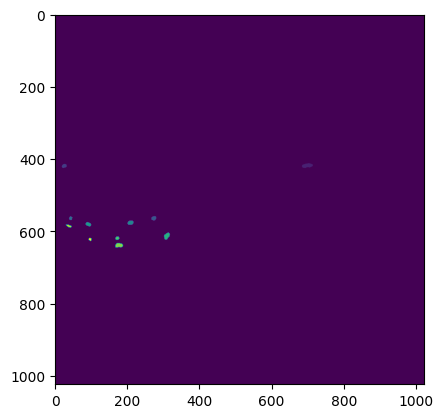

In [34]:
imshow(testfile)

In [48]:
'RFP_s01_f1440_z0001_seg.npy'.rsplit('_',1)[0]

'RFP_s01_f1440_z0001'

In [50]:
for file in os.listdir(path):
    if file.endswith('.npy'):
        npy_file_mask = np.load(join(path,file),allow_pickle=True).item()['masks']
        filename = file.rsplit('_',1)[0]
        imwrite(join(writefolder,filename+'.tif'), npy_file_mask)
        

## Play with Nd2File reader

In [1]:
from nd2 import ND2File

path = '/home/Test_images/nd2/Run3/c3z1t1v3.nd2'
with ND2File(path) as value:
    nd2meta = {**value.sizes}
    nd2meta['um_per_pixel'] = value.metadata.channels[0].volume.axesCalibration[:2]
    nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
    if nd2meta['T']>1:
        nd2meta['interval_sec'] = value.experiment[0].parameters.periodMs/1000
    else:
        nd2meta['interval_sec'] = None
    value.close()
    
nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
nd2meta['C'] = 1 if 'C' not in nd2meta else nd2meta['C']
nd2meta['Z'] = 1 if 'Z' not in nd2meta else nd2meta['Z']
nd2meta['P'] = 1 if 'P' not in nd2meta else nd2meta['P']

original_keys = ['C', 'Z', 'T', 'P', 'X', 'Y']
new_keys = ['full_n_channels', 'n_slices', 'n_frames', 'n_series', 'img_width', 'img_length']

for i, key in enumerate(original_keys):
    nd2meta[new_keys[i]] = nd2meta.pop(key)

nd2meta['axes'] = ''
nd2meta['file_type'] = '.nd2'

nd2meta

{'um_per_pixel': (0.325, 0.325),
 'interval_sec': None,
 'full_n_channels': 3,
 'n_slices': 1,
 'n_frames': 1,
 'n_series': 3,
 'img_width': 1024,
 'img_length': 1024,
 'axes': '',
 'file_type': '.nd2'}

In [2]:
with ND2File(path) as value:
    arr = value.asarray()
    value.close()
arr.shape

(3, 3, 1024, 1024)

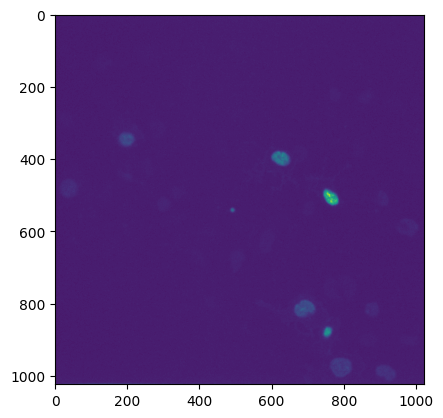

In [17]:
from matplotlib.pyplot import imshow
imshow(arr[(0,2)])

## Play with metadata


In [8]:
from __future__ import annotations
from tifffile import TiffFile

img_path = '/home/Test_images/tiff/Run3/c3z1t1v3s1.tif'

def calculate_um_per_pixel(meta_dict: dict) -> tuple[float,float]:
    """Calculate the um per pixel from the metadata of a tiff file. Output axes = (x,y)"""
    x_um_per_pix = round(1/meta_dict['XResolution'],ndigits=3)
    y_um_per_pix = round(1/meta_dict['YResolution'],ndigits=3)
    return x_um_per_pix,y_um_per_pix


tiff_meta = {}
# Open tif and read meta
with TiffFile(img_path) as tif:
    imagej_meta = tif.imagej_metadata
    imagej_meta['axes'] = tif.series[0].axes
    for page in tif.pages: # Add additional meta
        for tag in page.tags:
            if tag.name in ['ImageWidth','ImageLength',]:
                imagej_meta[tag.name] = tag.value
            if tag.name in ['XResolution','YResolution']:
                imagej_meta[tag.name] = tag.value[0]/tag.value[1]

if 'frames' not in imagej_meta: imagej_meta['frames'] = 1

if 'channels' not in imagej_meta: imagej_meta['channels'] = 1

if 'slices' not in imagej_meta: imagej_meta['slices'] = 1

if 'finterval' not in imagej_meta: 
    imagej_meta['finterval'] = None
else:
    imagej_meta['finterval'] = int(imagej_meta['finterval'])

original_keys = ['ImageWidth','ImageLength','frames','channels','slices','axes','finterval']
new_keys = ['img_width','img_length','n_frames','full_n_channels','n_slices','axes','interval_sec']

for i, key in enumerate(original_keys):
    tiff_meta[new_keys[i]] = imagej_meta[key]


tiff_meta['n_series'] = 1
tiff_meta['um_per_pixel'] = calculate_um_per_pixel(imagej_meta)

tiff_meta['file_type'] = '.tif'
tiff_meta

{'img_width': 1024,
 'img_length': 1024,
 'n_frames': 1,
 'full_n_channels': 3,
 'n_slices': 1,
 'axes': 'CYX',
 'interval_sec': None,
 'n_series': 1,
 'um_per_pixel': (0.325, 0.325),
 'file_type': '.tif'}

In [11]:
s = 'TZCYX'
s.replace('T','')

'ZCYX'

## Play with regionprops

In [1]:
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import erosion, disk
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

img_path = "/home/Test_images/masks/MAX_Images.tif"
stack_path = "/home/Test_images/masks/MAX_Merged.tif"
mask_path = "/home/Test_images/masks/Masks_IoU_Track.tif"

img = imread(img_path)
stack = imread(stack_path)
stack = np.moveaxis(stack, [1], [-1])
mask = imread(mask_path)

# m1 = mask[0].copy()
# m1[m1!=14] = 0
# eroded = erosion(m1, disk(5))
# m2 = m1-eroded
# lst_props = [regionprops(mask[i], intensity_image=stack[i]) for i in range(23)]
# properties_lst = ['area','centroid','intensity_mean',
#                        'label','perimeter','slice','solidity']
# lst_table = [regionprops_table(mask[i], intensity_image=stack[i],properties=properties_lst) for i in range(23)]
# df = pd.concat([pd.DataFrame(lst_table[i]) for i in range(23)])
# prop_img = regionprops(mask[0], intensity_image=img[0])
# prop_stack = regionprops(mask[0], intensity_image=stack[0])
# plt.imshow(m1)
# plt.show()
# plt.imshow(m2)
# plt.show()
# p1 = regionprops(m1, intensity_image=img[0])
# p2 = regionprops(m2, intensity_image=img[0])
props = regionprops_table(mask,properties=['slice','label'])

In [24]:
m1 = mask.copy()
m1[m1!=2] = 0
print(m1[0].shape)
prop = regionprops(m1[0])[0].centroid
prop

(512, 512)


(11.807221898660455, 365.82818870122304)

<class 'zip'>
(slice(0, 23, None), slice(0, 61, None), slice(212, 327, None))
(23, 61, 115)


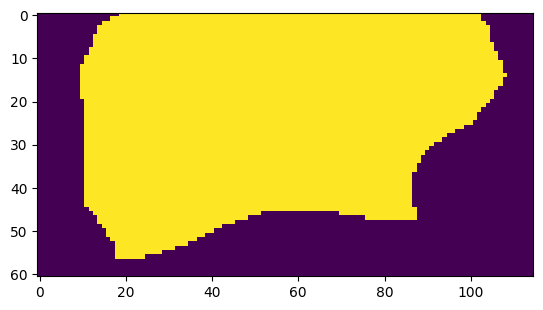

In [12]:
import matplotlib.pyplot as plt
slices,lables = props.values()
print(type(zip(*props.values())))
print(slices[0])
temp = mask[slices[0]]
temp[temp!=lables[0]] = 0
print(temp.shape)
plt.imshow(temp[0])

In [16]:
from __future__ import annotations
from skimage.measure import regionprops_table, regionprops
from skimage.measure._regionprops import RegionProperties
import numpy as np
from os import PathLike
import pandas as pd
from tifffile import imread
from concurrent.futures import ThreadPoolExecutor
import time


img_path = "/home/Test_images/masks/MAX_Images.tif"
stack_path = "/home/Test_images/masks/MAX_Merged.tif"
mask_path = "/home/Test_images/masks/Masks_IoU_Track.tif"

img = imread(img_path)
stack = imread(stack_path)
stack = np.moveaxis(stack, [1], [-1])
mask = imread(mask_path)


def regionprops_to_df(img_props: RegionProperties)-> pd.DataFrame:
    """
    Read content of all attributes for every item in a list
    output by skimage.measure.regionprops
    """

    attributes_list = ['area','centroid','intensity_mean',
                       'label','perimeter','slice','solidity']

    # Initialise list of lists for parsed data
    parsed_data = []
    # Put data from img_props into list of lists
    for i, img_prop in enumerate(img_props):
        parsed_data += [[]]
        for j in range(len(attributes_list)):
            parsed_data[i] += [getattr(img_prop, attributes_list[j])]
        
    # Return as a Pandas DataFrame
    return pd.DataFrame(parsed_data, columns=attributes_list)
        
def unpack_intensity(df: pd.DataFrame, channels: str | list[str])-> pd.DataFrame:
    """Unpack the intensity values from the regionprops DataFrame and add them as separate columns.
    The original output a tuple of intensities for each channel. This function will simply unpack
    the tuple and add the intensity values as separate columns for each channel.
    
    Args:
        df (pd.DataFrame): DataFrame containing the regionprops output.
        channels (list[str]): List of channel names.
    Returns:
        pd.DataFrame: DataFrame with the unpacked intensity values as separate columns for each channel."""
    
    # If only one channel is present, then the intensity_mean is a float, not a tuple
    if isinstance(df.intensity_mean[0], float):
        if len(channels)!=1:
            raise ValueError("Only one channel is present in the DataFrame. Please provide only 1 channel label.")
        
        if isinstance(channels, list):
            channels = channels[0]
        
        df.rename(columns={'intensity_mean': f'intensity_mean_{channels}'}, inplace=True)
        return df
    
    # If multiple channels are present, then the intensity_mean is a tuple of floats
    if len(channels)!=len(df.intensity_mean[0]):
        raise ValueError(f"The number of channels do not match the number of intensity values. \
            Please add {len(df.intensity_mean[0])} channel labels.")
    
    data = {channels[i]:[intensity[i] for intensity in df.intensity_mean] for i in range(len(channels))}
    attr_ind = df.columns.get_loc('intensity_mean')
    for i, channel in enumerate(channels):
        if i==0:
            df.intensity_mean = data[channel]
            df.rename(columns={'intensity_mean': f"intensity_mean_{channel}"}, inplace=True)
        else:
            df.insert(attr_ind+i, f"intensity_mean_{channel}", data[channel])
    return df

def extract_table(img_array: np.ndarray, mask_array: np.ndarray, channels: list[str], save_path: PathLike)-> pd.DataFrame:
    properties_lst = ['area','centroid','intensity_mean',
                       'label','perimeter','slice','solidity']
    col_rename= {'centroid_0':'centroid_y','centroid_1':'centroid_x'}
    def get_regionprops(frame: int)-> pd.DataFrame:
        """Nested function to extract the regionprops for each frame in multi-threading."""
        prop = regionprops_table(mask_array[frame], intensity_image=img_array[frame],
                                 properties=properties_lst,separator='_')
        df = pd.DataFrame(prop)
        # df = regionprops_to_df(prop)
        df['frame'] = frame+1
        return df

    # If the mask_array is not a time sequence
    if mask_array.ndim ==2:
        prop = regionprops_table(mask_array, intensity_image=img_array,
                                 properties=properties_lst,separator='_')
        master_df = pd.DataFrame(prop)
        master_df['frame'] = 1
        col_rename['intensity_mean'] = f'intensity_mean_{channels[0]}'
        master_df.rename(columns=col_rename, inplace=True)
        # master_df = unpack_intensity(master_df, channels)
        master_df.to_csv(save_path, index=False, header=True)
        return master_df
    
    # If the mask_array is a time sequence
    with ThreadPoolExecutor() as executor:
        lst_df = executor.map(get_regionprops, range(mask_array.shape[0]))
    
    # Create the DataFrame and save to csv
    master_df = pd.concat(lst_df, ignore_index=True)
    col_rename = {**col_rename,**{f'intensity_mean_{i}':f'intensity_mean_{channels[i]}' for i in range(len(channels))}}
    master_df.rename(columns=col_rename, inplace=True)
    master_df.to_csv(save_path, index=False, header=True)
    return master_df

def extract_data(img_array: np.ndarray, mask_array: np.ndarray, channels: list[str], save_path: PathLike)-> pd.DataFrame:
    def get_regionprops(frame: int)-> pd.DataFrame:
        """Nested function to extract the regionprops for each frame in multi-threading."""
        prop = regionprops(mask_array[frame], intensity_image=img_array[frame])
        df = regionprops_to_df(prop)
        df['frame'] = frame+1
        return unpack_intensity(df,channels)

    # If the mask_array is not a time sequence
    if mask_array.ndim ==2:
        prop = regionprops(mask_array, intensity_image=img_array)
        master_df = regionprops_to_df(prop)
        master_df['frame'] = 1
        master_df = unpack_intensity(master_df, channels)
        master_df.to_csv(save_path, index=False, header=True)
        return master_df
    
    # If the mask_array is a time sequence
    with ThreadPoolExecutor() as executor:
        lst_df = executor.map(get_regionprops, range(mask_array.shape[0]))
    
    # Create the DataFrame and save to csv
    master_df = pd.concat(lst_df, ignore_index=True)
    master_df.to_csv(save_path, index=False, header=True)
    return master_df

start = time.time()
master_df = extract_data(stack, mask, ['GFP','RFP'], '/home/Test_images/masks/regionprops.csv')
end1 = time.time()

# lst_df = [regionprops_to_df(prop) for prop in lst_props]
# lst_unpack = [unpack_intensity(df, ['GFP','RFP']) for df in lst_df]
# # Add the frame number to the DataFrame
# for i,df in enumerate(lst_unpack):
#     df['frame'] = i
# master_df = pd.concat(lst_unpack, ignore_index=True)
master_df = extract_table(stack, mask, ["GFP",'RFP'], '/home/Test_images/masks/regionprops.csv')
end2 = time.time()
print(f"Regionprops: {end1-start}, Regionprops_table: {end2-end1}")


Regionprops: 0.6202468872070312, Regionprops_table: 0.6223130226135254


In [54]:
import numpy as np
import time
start = time.time()
for value in np.unique(mask):
    is_complete = np.all(np.any(mask==value, axis=(1,2)))
    if not is_complete:
        print(value)
end = time.time()
print((end-start))


30
0.15466690063476562


In [64]:
start = time.time()
lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=23]
for value in obj_to_delete:
    print(value)
# for obj, cnt in np.unique(lst_obj,return_counts=True):
#     if cnt!=23:
#         print(obj)
end = time.time()
print((end-start))

30
0.04352402687072754


In [67]:
def trim_incomplete_track(array: np.ndarray)-> np.ndarray:
    """Function to trim the incomplete tracks from the mask stack.
    Args:
        array (np.ndarray): 3D Mask array in tyx format.
    Returns:
        np.ndarray: Mask array with incomplete tracks removed."""
    # Make a list of unique objects
    lst_obj = [np.unique(frame) for frame in array]
    lst_obj = np.concatenate(lst_obj) # Flatten the list
    # Count the number of occurences of each object
    obj,cnt = np.unique(lst_obj,return_counts=True)
    # Create a list of obj to remove
    obj_to_remove = obj[cnt!=20]
    for obj in obj_to_remove:
        array[array==obj] = 0
    return array
start = time.time()
mask = imread(mask_path)

lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=20]
print("Before: ",obj_to_delete)

mask = trim_incomplete_track(mask)

lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=20]
print("After: ",obj_to_delete)
end = time.time()
print((end-start))

Before:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35]
After:  [0]
0.1704254150390625


In [5]:
import numpy as np
maskNum = 35
intensity = np.nanmean(a=img,where=mask==maskNum)
intensity
print(intensity, prop[maskNum-1].intensity_mean)

117.43083573487031 117.43083573487031


In [4]:
from sys import getsizeof
getsizeof(prop)

424

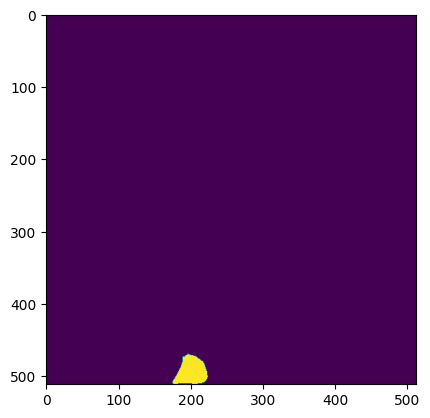

In [6]:
from matplotlib.pyplot import imshow
temp = mask.copy()
temp[temp!=maskNum] = 0
imshow(temp)

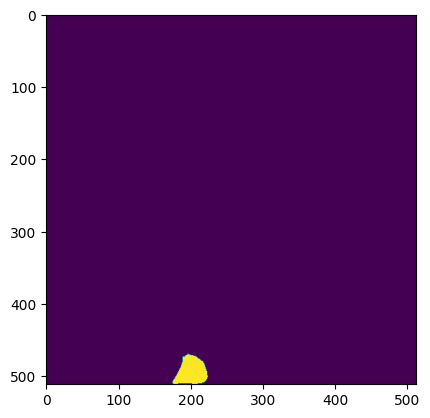

In [17]:
new_mask = np.zeros_like(mask)


value = prop[maskNum-1].coords.tolist()
for y,x in prop[maskNum-1].coords:
    new_mask[y,x] = maskNum
imshow(new_mask)

In [5]:
from importlib.metadata import version

version('ImageAnalysis')

import pkg_resources

def get_version():
    try:
        return pkg_resources.get_distribution("ImageAnalysis").version
    except pkg_resources.DistributionNotFound:
        return "Package not found"
print(get_version())

1.0.0


/tmp/ipykernel_79033/3457485119.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [50]:
d2 = {'a':1, 'b':5}
d1 = {'a':1, 'b':2, 'c':3}
d = {**d1, **d2}
d

{'a': 1, 'b': 5, 'c': 3}

In [15]:
from os import sep
input_fold = '/home/Test_images/nd2/Run2'
parent_path = input_fold.rsplit(sep,1)[0]
img_path = '/home/Test_images/nd2/Run2/treated/100mg/c2z25t23v1_nd2.nd2'
img = img_path.replace(parent_path,'').split(sep)[1:-1]
print(img)

['Run2', 'treated', '100mg']


In [16]:
from os import listdir
import re
scan = listdir('/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_002_Merged_s1/Images')
# frames = [re.search('f\d{4}', frame).group() for frame in scan if re.search('f\d{4}', frame)]
# len(set(frames))
channel_seg = "GFP"
file_type = '.tif'
any(channel_seg in file for file in scan if file.endswith(file_type))

False

In [13]:
d = {'b':1}

if d and 'a' in d:
    print('yes')
else:
    print('no')

no


In [6]:
import json
good = '/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_002_Merged_s1/exp_settings.json'

with open(good,'r') as fp:
    meta = json.load(fp)
meta['segmentation']['cellpose_seg']['RFP']['cellpose_eval']

{'batch_size': 8,
 'resample': True,
 'channels': [0, 0],
 'channel_axis': None,
 'z_axis': None,
 'normalize': {'percentile': [1, 99]},
 'invert': False,
 'rescale': None,
 'diameter': 30.0,
 'flow_threshold': 0.5,
 'cellprob_threshold': 0,
 'do_3D': False,
 'anisotropy': None,
 'stitch_threshold': 0.0,
 'min_size': 15,
 'niter': None,
 'augment': False,
 'tile': True,
 'tile_overlap': 0.1,
 'bsize': 224,
 'interp': True,
 'compute_masks': True,
 'progress': None}

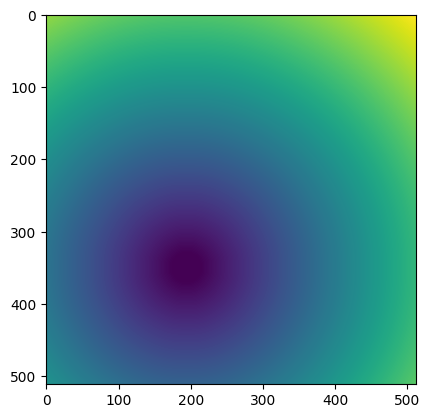

In [90]:
from tifffile import imread, imwrite
import numpy as np
from skimage.draw import disk
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table, regionprops
from mahotas import distance
from scipy.ndimage import distance_transform_edt

mask_path = '/home/Test_images/masks/Masks_IoU_Track.tif'
mask = imread(mask_path)
ref = np.ones_like(mask)
rr,cc = disk((350, 194), 20,)
ref[:,rr,cc] = 0
# ref = distance(ref,metric='euclidean')
ref = distance_transform_edt(ref)

imwrite('/home/Test_images/masks/mask_ref.tif', ref.astype('uint16'))
plt.imshow(ref[0])

In [94]:
mm = mask.copy()
mm[5,...][mm[5,...]==14] = 14
print(mm.shape)

(23, 512, 512)


In [97]:
lst = [np.unique(mm[i]) for i in range(mm.shape[0])]
obj_lst,cnt = np.unique(np.concatenate(lst),return_counts=True)
print(obj_lst,cnt)
# nc = [len(np.where(mask==i)) for i in obj_lst]
complete_track = obj_lst[cnt!=mm.shape[0]]
complete_track.size

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 37] [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23]


0

In [52]:
m1 = mask.copy()
m1[0] = 0
m1[-1] = 0
m1[m1!=14] = 0
props = zip(*regionprops_table(m1,properties=['slice','label']).values())
slice_obj,label = props
ref_f = slice(0,23)
obj_slice = (ref_f,*(slice_obj[1:]))
print(obj_slice)
temp = m1[obj_slice]
print(temp.shape)
# print(type(slice_obj[0]))
# obj1 = slice_obj[0]
# f,y,x = obj1
# # f = slice(0,23)
# print(f)
# obj2 = tuple((f,y,x))
# print(type(obj2))
# props['slice'] = np.array(obj2).astype(tuple)
# print(props)
# slice_obj = props['slice']
# print(type(slice_obj[0]))
# obj1==obj2

TypeError: 'zip' object is not subscriptable

In [25]:
def centroid_intensity(region, intensity_image):
    # Calculate the centroid coordinates as integers
    y, x = np.nonzero(region)
    y, x = int(np.mean(y)), int(np.mean(x))
    # Return the intensity at the centroid position
    return int(intensity_image[y,x])
poop = {}
prop = regionprops_table(mask[0], intensity_image=ref[0], properties=['label','mean_intensity'],extra_properties=[centroid_intensity])
poop['dmap'] = prop['centroid_intensity']*.32
poop

{'dmap': array([100.48, 115.2 , 123.84,  93.12, 126.4 , 104.32,  72.32, 108.8 ,
         72.96,  91.84,  54.72,  72.32,  54.08,  37.76,  60.16,  63.68,
         48.  ,  31.04,  49.6 ,  35.84,  81.6 ,  42.24,  26.88,  22.4 ,
         30.08,  43.84,  37.12,  39.68,  62.4 ,  53.76,  85.44,  52.48,
         82.88,  56.32,  65.28])}

In [29]:
def centroid_intensity(region, intensity_image):
    # Calculate the centroid coordinates as integers
    y, x = np.nonzero(region)
    # Return the intensity at the centroid position
    return intensity_image[int(np.mean(y)), int(np.mean(x))]
m1 = mask[0].copy()
m1[m1!=14] = 0
y,x = np.nonzero(m1)
y,x = int(np.mean(y)), int(np.mean(x))
print(y,x)
ref[0,y,x]
centroid_intensity(m1,ref[0])

232 266


118.51160280748886

In [51]:
from os import scandir

path = '/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_003_Merged_s1/test'
any(scandir(path))

False

In [17]:
from os import listdir
channel_seg = 'GFP'
s = '/home/Test_images/tiff/Run2/c2z25t23v1_tif_s1/Images_Registered'
any(channel_seg in file for file in sorted(listdir(s)) if file.endswith('.tif'))

True

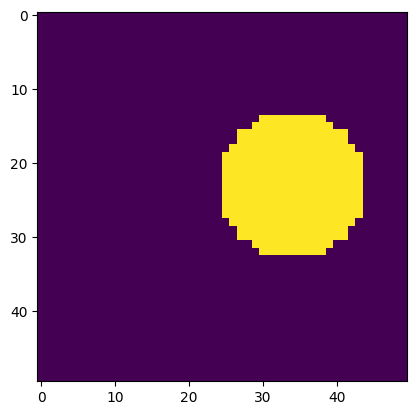

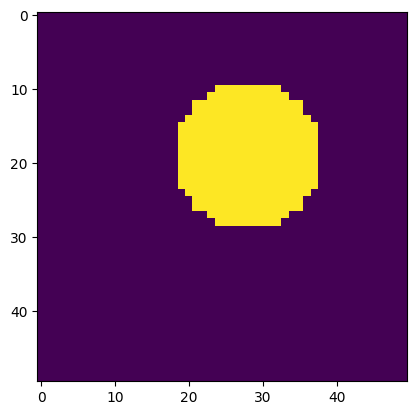

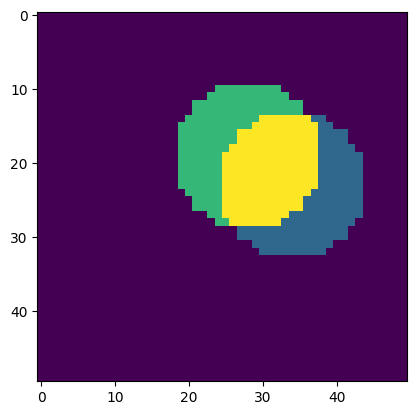

In [74]:
import numpy as np
from skimage.draw import disk
import matplotlib.pyplot as plt

mask1 = np.zeros((50,50),dtype=np.uint8)
rr,cc = disk((23,34),10)
mask1[rr,cc] = 1
mask2 = np.zeros((50,50),dtype=np.uint8)
rr,cc = disk((19,28),10)
mask2[rr,cc] = 2
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()
# zero_arr = mask1==0
# mask1[zero_arr] += mask2[zero_arr]
mask1 += mask2
plt.imshow(mask1)
plt.show()

## Test the pipeline display

In [1]:
from pipeline.main import run_pipeline
from pipeline.settings.settings_dict import settings


df = run_pipeline(settings)


===== Initializing the ImageExtractionModule Module =====

Extracting images =====
... Searching for ('.nd2', '.tif', '.tiff') files in /home/Test_images/nd2/Run2 ...


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]


-> Extracting metadata from /home/Test_images/nd2/Run2/c2z25t23v1_nd2.nd2
 --> Creating image sequence for /home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1
  ---> Saving folder already exists: c2z25t23v1_nd2_s1/Images
  ---> Images have already been converted to image sequence

===== Loading the PreProcessModule Module =====

Preprocessing images =====

-> Removing background from images


Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

--> Applying background substraction to /home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1


  0%|          | 0/1150 [00:00<?, ?it/s]


Preprocess done =====

===== Loading the SegmentationModule Module =====

Segmentation process started =====

-> Segmenting images with cellpose


Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

 --> Segmenting cells in /home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1
  ---> Saving folder already exists: c2z25t23v1_nd2_s1/Masks_Cellpose
  ---> Segmenting cells as .tif for the 'RFP' channel
2024-06-03 09:25:19,479 [INFO] WRITING LOG OUTPUT TO /home/cpdev/.cellpose/run.log
2024-06-03 09:25:19,479 [INFO] 
cellpose version: 	3.0.7 
platform:       	linux 
python version: 	3.8.13 
torch version:  	1.11.0
2024-06-03 09:25:19,480 [INFO] >> cyto2 << model set to be used
2024-06-03 09:25:19,509 [INFO] ** TORCH CUDA version installed and working. **
2024-06-03 09:25:19,510 [INFO] >>>> using GPU
2024-06-03 09:25:19,603 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


  0%|          | 0/23 [00:00<?, ?it/s]


Segmentation done =====

===== Loading the TrackingModule Module =====

-> Tracking images with IOU


Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

 --> Tracking cells in /home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1
  ---> Saving folder already exists: c2z25t23v1_nd2_s1/Masks_IoU_Track
  ---> Tracking cells for the 'RFP' channel
  ---> Tracking cells...


100%|██████████| 22/22 [00:00<00:00, 40.41it/s]


  ---> Creating master mask
  ---> Checking mask similarity


  0%|          | 0/86 [00:00<?, ?it/s]

  ---> Morphing missing masks


  0%|          | 0/55 [00:00<?, ?it/s]

  ---> Reconstructing mask


  0%|          | 0/55 [00:00<?, ?it/s]

  ---> Trimming incomplete tracks
  ---> Reassigning masks value


  0%|          | 0/23 [00:00<?, ?it/s]


===== Loading the AnalysisModule Module =====


Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data from /home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/regionprops.csv


## Play with heatmap

In [1]:
import pandas as pd

col_ind = ['intensity_mean_YFP','label','dmap_um_wound','frame']
cont_path = '/home/Test_images/szimi/MET/20240515-fMLF_diffusion/control/control_001_s1/regionprops.csv'
cont = pd.read_csv(cont_path).loc[:,col_ind].copy()
fmlp_path = '/home/Test_images/szimi/MET/20240515-fMLF_diffusion/FPR_1/FPR1_001_s1/regionprops.csv'
fmlp = pd.read_csv(fmlp_path).loc[:,col_ind].copy()

In [2]:
cont

,intensity_mean_YFP,label,dmap_um_wound,frame
0,615.036424,1,27.907,1
1,1199.821111,2,46.728,1
2,712.143498,3,70.092,1
3,1052.831522,4,87.615,1
4,631.303738,5,115.522,1
...,...,...,...,...
68973,2756.878723,754,110.979,91
68974,2648.730574,755,441.320,91
68975,1747.586305,756,449.108,91
68976,828.060000,757,566.577,91


In [2]:
import numpy as np
# Create an average dmap for the control


# Determine the number of bins
step = 5
nbin = np.arange(start=cont['dmap_um_wound'].min(),stop=cont['dmap_um_wound'].max()+step,step=step)
cont.loc[:,'bin'] = pd.cut(cont.loc[:,'dmap_um_wound'],bins=nbin)
cont

,intensity_mean_YFP,label,dmap_um_wound,frame,bin
0,615.036424,1,27.907,1,"(27.596, 32.596]"
1,1199.821111,2,46.728,1,"(42.596, 47.596]"
2,712.143498,3,70.092,1,"(67.596, 72.596]"
3,1052.831522,4,87.615,1,"(87.596, 92.596]"
4,631.303738,5,115.522,1,"(112.596, 117.596]"
...,...,...,...,...,...
68973,2756.878723,754,110.979,91,"(107.596, 112.596]"
68974,2648.730574,755,441.320,91,"(437.596, 442.596]"
68975,1747.586305,756,449.108,91,"(447.596, 452.596]"
68976,828.060000,757,566.577,91,"(562.596, 567.596]"


In [4]:
cont['bin'].value_counts().sort_index().tail(20)

bin
(762.596, 767.596]     80
(767.596, 772.596]    146
(772.596, 777.596]    325
(777.596, 782.596]    158
(782.596, 787.596]    273
(787.596, 792.596]    182
(792.596, 797.596]     91
(797.596, 802.596]     91
(802.596, 807.596]     91
(807.596, 812.596]    182
(812.596, 817.596]    117
(817.596, 822.596]     65
(822.596, 827.596]     91
(827.596, 832.596]      0
(832.596, 837.596]     91
(837.596, 842.596]      0
(842.596, 847.596]      0
(847.596, 852.596]      0
(852.596, 857.596]      0
(857.596, 862.596]     91
Name: count, dtype: int64

In [3]:
bin_df = cont.groupby(['frame','bin']).mean().reset_index().pivot(index='frame',columns='bin',values='intensity_mean_YFP').T
for idx in bin_df.index:
    bin_df.loc[idx,'bin_start'] = int(idx.left)
bin_df.set_index('bin_start',inplace=True)
bin_df

frame,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,91
bin_start,,,,,,,,,,,,,,,,,,,,,
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,473.750769,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12.0,1274.546737,1251.929167,1253.521024,1323.479440,1250.496559,1260.630833,1372.852491,1371.349510,1427.205266,1441.916175,...,1338.346859,1270.358795,1279.553123,1272.352158,1339.412868,1340.656661,1336.474338,1272.545694,1273.248654,1293.709395
17.0,447.071279,440.947589,444.781971,465.362683,447.966457,454.421384,533.568134,526.366876,543.469602,561.157233,...,499.076063,482.393258,485.564045,480.403471,490.498965,494.288703,487.983982,467.751037,468.327394,467.440748
22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.004372,621.842623,624.434973,631.986052,662.565451,659.104077,656.442060,632.945279,631.182403,641.318670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
847.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AttributeError: 'Axes' object has no attribute 'show'

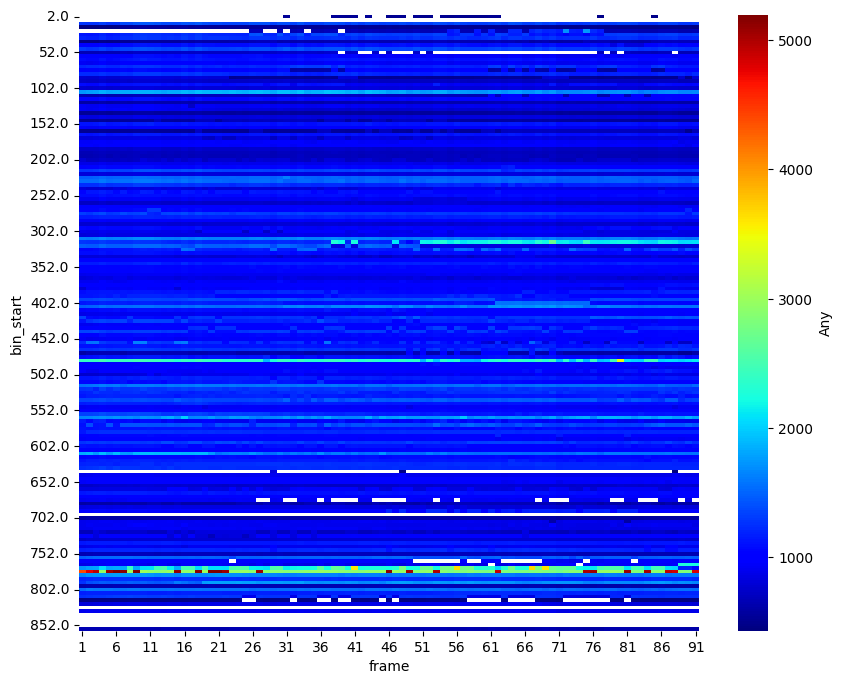

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
plot_args = {'cmap':'jet','yticklabels':10,'xticklabels':5,'cbar_kws':{'label': "Any"}}

fig = plt.figure(figsize=(10, 8))  # Adjust the size as needed
# plt.rcParams['pdf.fonttype'] = 42

ax = sns.heatmap(bin_df,**plot_args)  # You can change the colormap as needed


<Axes: xlabel='bin_start'>

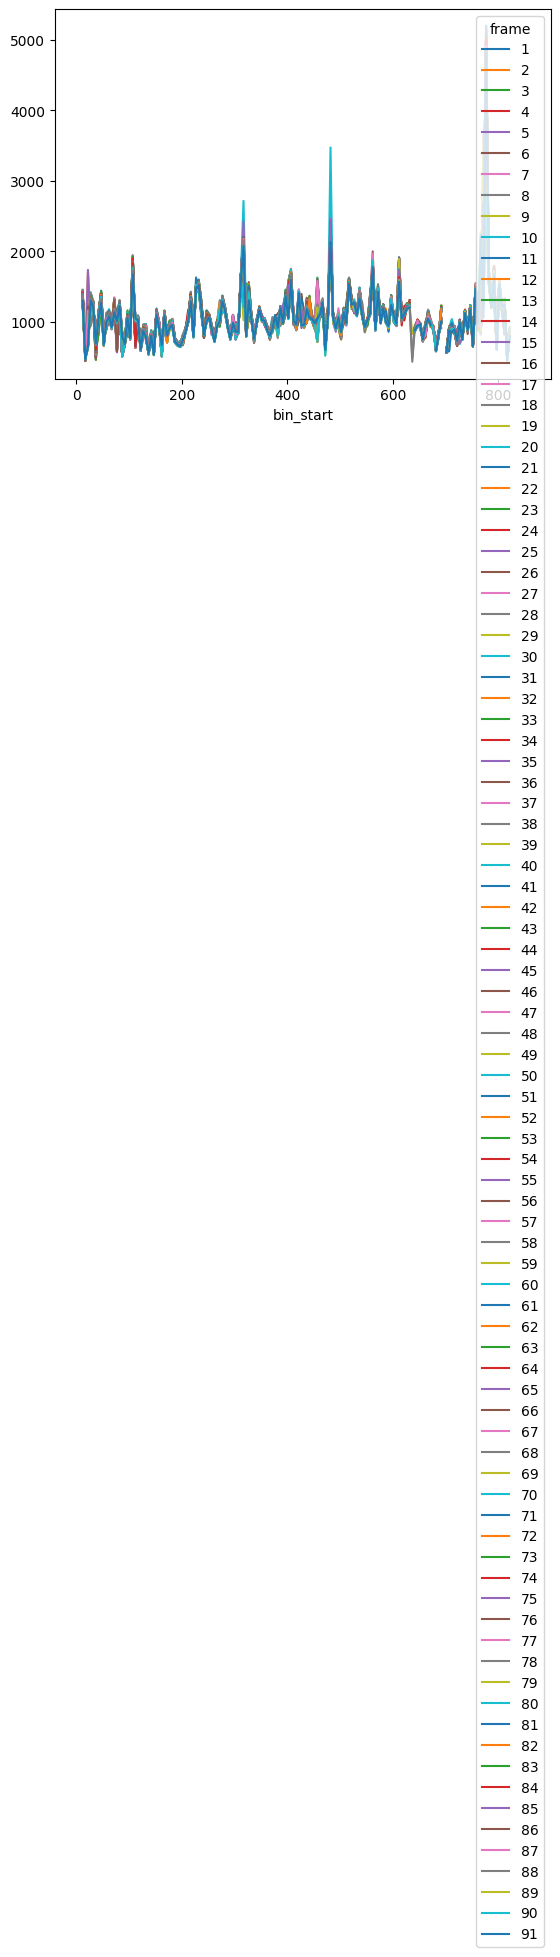

In [11]:
bin_df.plot()

## Play with overlap for mask class

In [13]:
import numpy as np
from cellpose.metrics import _intersection_over_union
from time import time
from tifffile import imread

def calculate_iou(mask1, mask2):
    # Calculate Intersection over Union (IoU)
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

mask1 = imread('/home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/Masks_Cellpose/RFP_s01_f0001_z0001.tif')
mask1[mask1!=24] = 0
mask2 = imread('/home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/Masks_Cellpose/RFP_s01_f0002_z0001.tif')

t1 = time()
iou = calculate_iou(mask1, mask2)
t2 = time()
iou2 = _intersection_over_union(mask1, mask2)
t3 = time()
print(iou)
print(iou2)
print(f"iou = {t2-t1} iou2 = {t3-t2}")

1.8826010015437328e-05
[[0.79737395 0.00564509 0.00381342 ... 0.00155846 0.00836181 0.00430597]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01074785 0.         0.         ... 0.         0.         0.        ]]
iou = 0.0002186298370361328 iou2 = 0.5172138214111328
